In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exp_name = "exp_compass"
exp_number = "exp_debug"
base_path = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/"
data_path = base_path + "/my_code/Bayesian-fairness/data"
save_path = base_path + f"/my_code/Bayesian-fairness/results/continuous/{exp_name}/{exp_number}"

# load data


In [3]:
def encode_data(data,unique_values):
    encoded_value = np.array([])
    for i, d in data.iterrows():
        # encode feature to an index represents the unique value.
        index = np.argmax((d.values == unique_values).all(axis=1))
        encoded_value = np.append(encoded_value, index)
    return encoded_value.astype(int)

In [4]:
# set atributes
Z_atr = ["sex", "race"]
X_atr = ['age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree']
Y_atr = 'two_year_recid'

# clip_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]

In [5]:
dataset = pd.read_csv(data_path + "/compas.csv")

In [6]:
# get distinct values
unique_z = np.unique(dataset[Z_atr].values, axis=0)
n_z = len(unique_z)

unique_y = np.unique(dataset[Y_atr].values, axis=0)
n_y = len(unique_y)

unique_x = np.unique(dataset[X_atr].values, axis=0)
n_x = len(unique_x)

In [7]:
print("Unique Z values:", n_z)
print("Unique X values:", n_x)
print("Unique Y values:", n_y)

Unique Z values: 12
Unique X values: 604
Unique Y values: 2


In [8]:
# encode z for convenience
dataset["z"] = encode_data(dataset[Z_atr], unique_values=unique_z)

In [9]:
Z_atr = "z"

In [10]:
train_data = dataset.iloc[0:6000]
test_data = dataset.iloc[6000:]

In [11]:
print("training size:", train_data.shape)
print("testing size:", test_data.shape)

training size: (6000, 10)
testing size: (1214, 10)


# model

In [12]:
def calc_freq(data, n):
    """ calculate frequency of 1D array"""
    P = np.zeros(n)
    for value in range(n):
        mask =  data == value
        P[value] = mask.mean()
    return P

def get_models(data):
    # Py
    Py = calc_freq(data[Y_atr], n_y)
    
    # Pz_y
    Pz_y = np.zeros((n_z, n_y))
    for y in range(n_y):
        mask = data[Y_atr] == y
        Pz_y[:, y] = calc_freq(data.loc[mask, Z_atr], n_z)
    
    # Py_x
    from sklearn.linear_model import LogisticRegression
    model_y_x = LogisticRegression(max_iter=1000)
    model_y_x.fit(X = data[X_atr], y = data[Y_atr])
    
    # Pz_yx
    unique_z_values = data[Z_atr].unique()
    missing_z = [z for z in range(12) if z not in unique_z_values]

    if missing_z:
        random_data = np.random.randint(low= 0 , high=2, size = (1, len(data.columns)))
        fake_df = pd.DataFrame(random_data,columns = data.columns)
        fake_df[Z_atr] = missing_z
        data = pd.concat([data, fake_df]) 
    
    input_features = [Y_atr] + X_atr
    model_z_yx = LogisticRegression(max_iter=1000)
    model_z_yx.fit(X = data[input_features], y = data[Z_atr])
    
    return Py, Pz_y, model_y_x, model_z_yx

In [13]:
test_data.shape

(1214, 10)

In [14]:
test_model = get_models(test_data)

In [15]:
test_data.shape

(1214, 10)

# Train policy

In [16]:
num_X = n_x # number of features
num_Y = n_y # number of outcomes
num_Z = n_z # number of sensitive features
num_A = 2 # number of actions

In [17]:
# parameters
n_iter = 400 # number of itteration for SGD
lr = 1.0 # learning rate
l = 0.5 # lambda

# Functions

In [18]:
def get_eye_utility(size):
    return np.eye(size)

utility = get_eye_utility(size=2)

# Algorithm
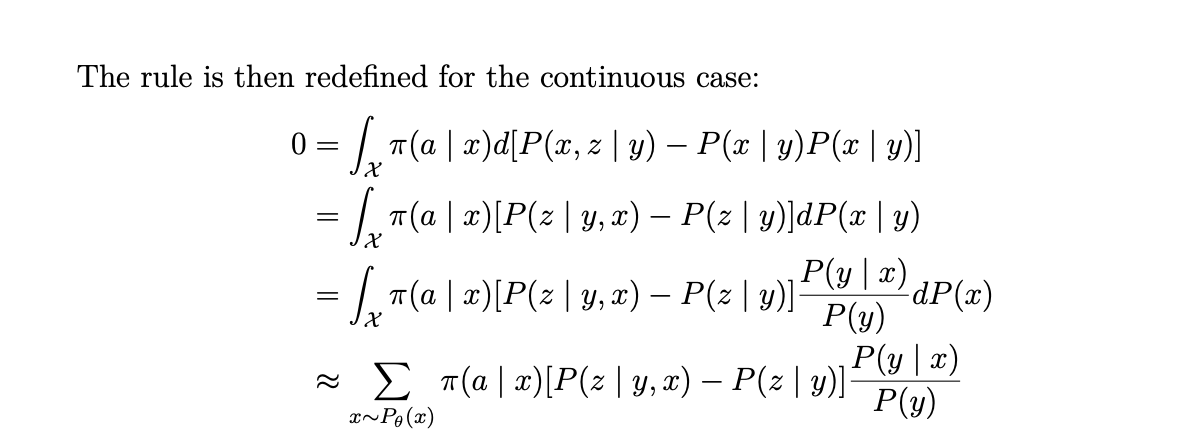

In [19]:
def get_fairness_loss(Pa_x, Py, Pz_y, model_y_x, model_z_yx):
    delta = (model_z_yx / Pz_y - 1 ) * (model_y_x / Py)
#     delta = tf.math.abs(delta
    delta = tf.reshape(delta,(-1,1))
    f =  Pa_x * delta
#     tf.print("shape delta", tf.shape(delta))
#     tf.print("shape Pa_x",tf.shape(Pa_x))
#     tf.print("shape f",tf.shape(f))
#     tf.print(tf.shape(f))
#     tf.print(f)
    
    return tf.math.abs(tf.math.reduce_mean(f)) * 10

In [20]:
def get_utility_loss(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    neg_utility = - utility
    return tf.math.reduce_mean(neg_utility)

In [21]:
def get_utility_metric(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    return tf.math.reduce_mean(utility)

In [22]:
import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter


utility_tracker = tf.keras.metrics.Mean(name="utility")
fairness_tracker = tf.keras.metrics.Mean(name="fairness")
loss_tracker = tf.keras.metrics.Mean(name="loss")


class LogisticRegresionTF(tf.keras.Model):
    """
    logistic regresion model , tensorflow
    """
    def __init__(self, input_dim, l):
        super(LogisticRegresionTF, self).__init__()
        self.l = l
        
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, 1), dtype="float32"),
            trainable=True,
        )
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(), dtype="float32"),
            trainable=True
        )

    def call(self, inputs):
        return tf.nn.sigmoid(tf.matmul(inputs,self.w) + self.b)

    def train_step(self, data):
        x, y = data
        x, Py, Pz_y, model_y_x, model_z_yx = x[:,:6], x[:,6],x[:,7],x[:,8],x[:,9]
        # Run forward pass.
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            utility = get_utility_loss(y_true = y, y_pred = y_pred)
            fairness = get_fairness_loss(y_pred, Py, Pz_y, model_y_x, model_z_yx)
            loss = (1-self.l) * utility + self.l * fairness 
            
        self._validate_target_and_loss(y, loss)
        # Run backwards pass.
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        
        # update metrics
        loss_tracker.update_state(loss)
        utility_tracker.update_state(get_utility_metric(y_true = y, y_pred = y_pred))
        fairness_tracker.update_state(fairness)
        
        metrics = self.compute_metrics(x, y, y_pred,None)
        metrics["fairness_loss"] = fairness_tracker.result()  
        metrics["utility"] = utility_tracker.result()
        metrics["loss"] = loss_tracker.result() 
#         tf.print(fairness_loss)
        return metrics
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker , fairness_tracker, utility_tracker] + self.compiled_metrics.metrics

In [23]:
Py, Pz_y, model_y_x, model_z_yx = get_models(train_data)

In [24]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [25]:
# input_dataset = tf.data.Dataset.from_tensor_slices((train_data[X_atr].astype("float32").values,
#            data_Py,
#            data_Pz_y,
#            data_Py_z,
#            data_Pz_yx)
# )
# labels_dataset = tf.data.Dataset.from_tensor_slices(train_data[Y_atr])
# tf_train_dataset = tf.data.Dataset.zip((input_dataset, labels_dataset))
# tf_train_dataset.shuffle(1000).batch(64).repeat()

In [26]:
policy_model = LogisticRegresionTF(input_dim=len(X_atr), l = 0.0)

In [27]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
policy_model.compile(optimizer=optimizer,
               metrics = ["accuracy"])

In [28]:
in_df = train_data[X_atr].astype("float32")
in_df["Py"] = data_Py
in_df["Pz_y"] = data_Pz_y
in_df["Py_z"] = data_Py_z
in_df["Pz_yx"] = data_Pz_yx

In [29]:
in_df

,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,Py,Pz_y,Py_z,Pz_yx
0,2.0,0.0,0.0,0.0,0.0,1.0,0.551,0.049002,0.806851,0.059295
1,1.0,0.0,0.0,0.0,0.0,1.0,0.449,0.509651,0.330786,0.380325
2,0.0,0.0,0.0,1.0,4.0,1.0,0.449,0.509651,0.690225,0.618515
3,0.0,0.0,1.0,0.0,1.0,1.0,0.551,0.351180,0.436171,0.478386
4,1.0,0.0,0.0,0.0,2.0,1.0,0.551,0.049002,0.598783,0.052283
...,...,...,...,...,...,...,...,...,...,...
5995,1.0,0.0,0.0,0.0,22.0,1.0,0.449,0.509651,0.933514,0.837547
5996,1.0,0.0,0.0,0.0,0.0,1.0,0.449,0.004454,0.330786,0.011815
5997,2.0,0.0,0.0,0.0,2.0,1.0,0.449,0.242019,0.245004,0.401558
5998,1.0,0.0,0.0,0.0,5.0,0.0,0.551,0.351180,0.524162,0.397598


In [30]:
history = policy_model.fit(x = in_df.astype("float32"),
                           y = train_data[Y_atr].astype("float32"),
                           epochs=400,
                           batch_size=train_data[Y_atr].shape[0],
                           shuffle=True).history

Epoch 1/400
1/1 [==============================] - 0s 178ms/step - loss: -0.4807 - fairness: 0.4664 - utility: 0.4807 - accuracy: 0.3732 - fairness_loss: 0.4664
Epoch 2/400
1/1 [==============================] - 0s 3ms/step - loss: -0.4848 - fairness: 0.4939 - utility: 0.4848 - accuracy: 0.3730 - fairness_loss: 0.4939
Epoch 3/400
1/1 [==============================] - 0s 2ms/step - loss: -0.4900 - fairness: 0.5298 - utility: 0.4900 - accuracy: 0.3563 - fairness_loss: 0.5298
Epoch 4/400
1/1 [==============================] - 0s 2ms/step - loss: -0.4960 - fairness: 0.5733 - utility: 0.4960 - accuracy: 0.3897 - fairness_loss: 0.5733
Epoch 5/400
1/1 [==============================] - ETA: 0s - loss: -0.5023 - fairness: 0.6193 - utility: 0.5023 - accuracy: 0.4527 - fairness_loss: 0.6193

2023-01-24 12:25:36.067731: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 4ms/step - loss: -0.5023 - fairness: 0.6193 - utility: 0.5023 - accuracy: 0.4527 - fairness_loss: 0.6193
Epoch 6/400
1/1 [==============================] - 0s 3ms/step - loss: -0.5079 - fairness: 0.6596 - utility: 0.5079 - accuracy: 0.4583 - fairness_loss: 0.6596
Epoch 7/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5125 - fairness: 0.6903 - utility: 0.5125 - accuracy: 0.4593 - fairness_loss: 0.6903
Epoch 8/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5161 - fairness: 0.7124 - utility: 0.5161 - accuracy: 0.4592 - fairness_loss: 0.7124
Epoch 9/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5189 - fairness: 0.7281 - utility: 0.5189 - accuracy: 0.4598 - fairness_loss: 0.7281
Epoch 10/400
1/1 [==============================] - 0s 3ms/step - loss: -0.5213 - fairness: 0.7396 - utility: 0.5213 - accuracy: 0.4922 - fairness_loss: 0.7396
Epoch 11/400
1/1 [==============================] - 0s 3m

1/1 [==============================] - 0s 2ms/step - loss: -0.5888 - fairness: 0.6682 - utility: 0.5888 - accuracy: 0.6640 - fairness_loss: 0.6682
Epoch 108/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5892 - fairness: 0.6672 - utility: 0.5892 - accuracy: 0.6640 - fairness_loss: 0.6672
Epoch 109/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5896 - fairness: 0.6663 - utility: 0.5896 - accuracy: 0.6640 - fairness_loss: 0.6663
Epoch 110/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5900 - fairness: 0.6653 - utility: 0.5900 - accuracy: 0.6640 - fairness_loss: 0.6653
Epoch 111/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5904 - fairness: 0.6643 - utility: 0.5904 - accuracy: 0.6640 - fairness_loss: 0.6643
Epoch 112/400
1/1 [==============================] - 0s 2ms/step - loss: -0.5908 - fairness: 0.6634 - utility: 0.5908 - accuracy: 0.6628 - fairness_loss: 0.6634
Epoch 113/400
1/1 [=============================

Epoch 158/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6056 - fairness: 0.6302 - utility: 0.6056 - accuracy: 0.6650 - fairness_loss: 0.6302
Epoch 159/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6058 - fairness: 0.6296 - utility: 0.6058 - accuracy: 0.6650 - fairness_loss: 0.6296
Epoch 160/400
1/1 [==============================] - 0s 3ms/step - loss: -0.6061 - fairness: 0.6291 - utility: 0.6061 - accuracy: 0.6650 - fairness_loss: 0.6291
Epoch 161/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6063 - fairness: 0.6286 - utility: 0.6063 - accuracy: 0.6650 - fairness_loss: 0.6286
Epoch 162/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6066 - fairness: 0.6281 - utility: 0.6066 - accuracy: 0.6650 - fairness_loss: 0.6281
Epoch 163/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6068 - fairness: 0.6275 - utility: 0.6068 - accuracy: 0.6650 - fairness_loss: 0.6275
Epoch 164/400
1/1 [===============

Epoch 259/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6231 - fairness: 0.5969 - utility: 0.6231 - accuracy: 0.6660 - fairness_loss: 0.5969
Epoch 260/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6232 - fairness: 0.5967 - utility: 0.6232 - accuracy: 0.6660 - fairness_loss: 0.5967
Epoch 261/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6233 - fairness: 0.5965 - utility: 0.6233 - accuracy: 0.6660 - fairness_loss: 0.5965
Epoch 262/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6235 - fairness: 0.5963 - utility: 0.6235 - accuracy: 0.6660 - fairness_loss: 0.5963
Epoch 263/400
1/1 [==============================] - 0s 3ms/step - loss: -0.6236 - fairness: 0.5961 - utility: 0.6236 - accuracy: 0.6660 - fairness_loss: 0.5961
Epoch 264/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6237 - fairness: 0.5959 - utility: 0.6237 - accuracy: 0.6660 - fairness_loss: 0.5959
Epoch 265/400
1/1 [===============

Epoch 360/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6320 - fairness: 0.5834 - utility: 0.6320 - accuracy: 0.6667 - fairness_loss: 0.5834
Epoch 361/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6321 - fairness: 0.5833 - utility: 0.6321 - accuracy: 0.6667 - fairness_loss: 0.5833
Epoch 362/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6322 - fairness: 0.5832 - utility: 0.6322 - accuracy: 0.6667 - fairness_loss: 0.5832
Epoch 363/400
1/1 [==============================] - 0s 3ms/step - loss: -0.6322 - fairness: 0.5832 - utility: 0.6322 - accuracy: 0.6667 - fairness_loss: 0.5832
Epoch 364/400
1/1 [==============================] - 0s 3ms/step - loss: -0.6323 - fairness: 0.5831 - utility: 0.6323 - accuracy: 0.6667 - fairness_loss: 0.5831
Epoch 365/400
1/1 [==============================] - 0s 2ms/step - loss: -0.6324 - fairness: 0.5830 - utility: 0.6324 - accuracy: 0.6667 - fairness_loss: 0.5830
Epoch 366/400
1/1 [===============

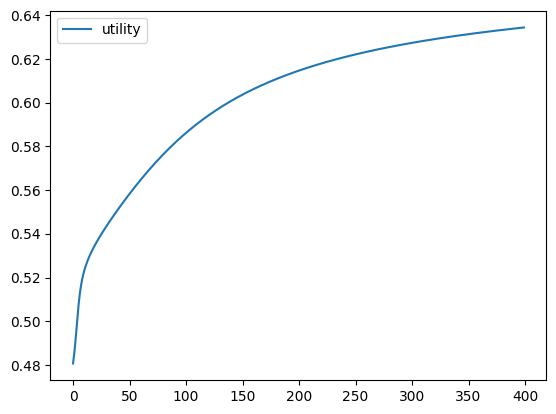

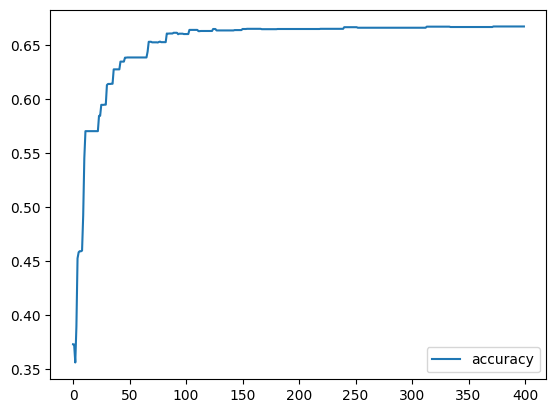

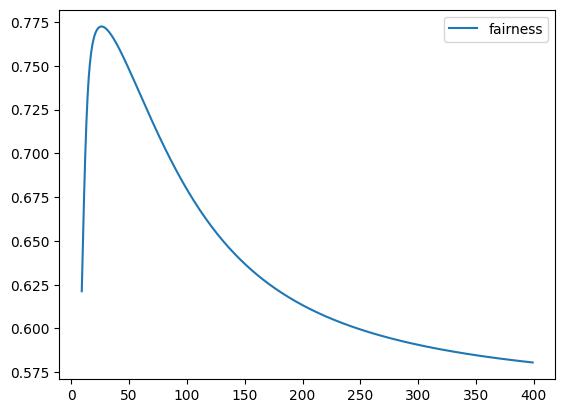

In [31]:
plt.figure()
plt.plot(history["utility"],label="utility")
# plt.plot(history["val_loss"],label="val_loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["accuracy"],label="accuracy")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(pd.DataFrame(history["fairness_loss"]).rolling(10).mean(),label="fairness")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

In [32]:
history["fairness_loss"]

[0.4664188623428345,
 0.4939269721508026,
 0.5297913551330566,
 0.5733465552330017,
 0.6192838549613953,
 0.6596049666404724,
 0.6903026103973389,
 0.7123504877090454,
 0.7281379699707031,
 0.7396354675292969,
 0.748175859451294,
 0.754625678062439,
 0.7595540285110474,
 0.7633442282676697,
 0.7662612795829773,
 0.7684942483901978,
 0.7701801657676697,
 0.7714219093322754,
 0.7722976803779602,
 0.7728678584098816,
 0.7731800079345703,
 0.7732723951339722,
 0.7731761932373047,
 0.772916316986084,
 0.7725139856338501,
 0.7719867825508118,
 0.7713493704795837,
 0.7706143856048584,
 0.7697931528091431,
 0.768894612789154,
 0.7679272294044495,
 0.7668981552124023,
 0.7658137083053589,
 0.7646791934967041,
 0.7635002732276917,
 0.762281060218811,
 0.7610254287719727,
 0.7597372531890869,
 0.758419930934906,
 0.7570761442184448,
 0.755709171295166,
 0.7543212175369263,
 0.752914547920227,
 0.7514914870262146,
 0.7500540614128113,
 0.7486038208007812,
 0.7471426725387573,
 0.7456722855567932,


# Metrics

# empirical utility

In [33]:
p_a1 = policy_model.predict(in_df[X_atr])
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T
ys = train_data[[Y_atr]].values.ravel()
a_pred = np.argmax(p_a_x, axis=0)

188/188 [==============================] - 0s 247us/step


In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true =  ys, y_pred=a_pred)

0.6671666666666667

In [36]:
def empirical_utility_v1(p_a_x, ys, utility):
    EU = 0
    for x, y in enumerate(ys):
        for a in range(2):
            EU += utility[a,y]* p_a_x[a, x]
    EU = EU / ys.shape[0]
    return EU

def empirical_utility_v2(p_a_x, ys, a, utility):
    EU = 0
    for x, (y, a) in enumerate(zip(ys, a)):
        EU += utility[a, y]* p_a_x[a, x]
    EU = EU / ys.shape[0]
    return EU

In [39]:
empirical_utility_v1(p_a_x, ys, utility)

0.6345148725981513

In [40]:
empirical_utility_v2(p_a_x, ys, a_pred, utility)

0.5675447360078494

In [41]:
p_a_x

array([[0.9846797 , 0.936638  , 0.12509233, ..., 0.93432784, 0.19843161,
        0.96798915],
       [0.01532029, 0.06336201, 0.8749077 , ..., 0.06567215, 0.8015684 ,
        0.03201087]], dtype=float32)

# empirical fairness

In [42]:
def empirical_fairness_v21(datas, model, policy):
    
    Z = 12

    EF = 0
    for z in range(Z):
        c = 0
        for i,(x, y) in datas.iterrows():
            delta = (model.Pz_yx[z, y, x]/model.Pz_y[z, y] - 1 )/(model.Py[y])
            c += policy[:, x] * delta
        c = c/datas.shape[0]
        c = np.linalg.norm(c, 1)
        EF += c
    return EF

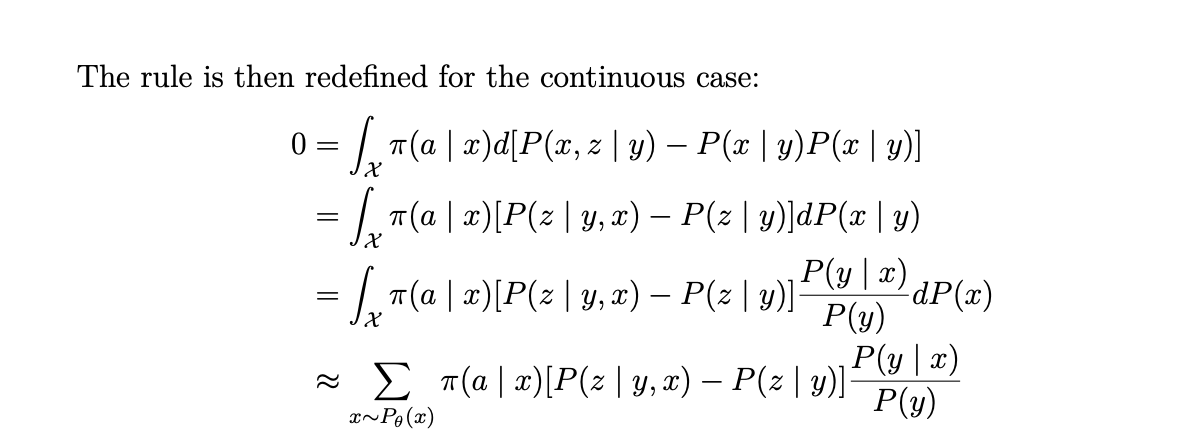

In [43]:
Py, Pz_y, model_y_x, model_z_yx

(array([0.551, 0.449]),
 array([[4.90018149e-02, 3.74907201e-02],
        [3.51179673e-01, 5.09651076e-01],
        [2.79794313e-01, 2.42019302e-01],
        [8.52994555e-02, 6.01336303e-02],
        [6.35208711e-03, 2.22717149e-03],
        [2.11736237e-03, 2.22717149e-03],
        [1.24016939e-02, 4.45434298e-03],
        [1.03448276e-01, 6.97847068e-02],
        [9.31639443e-02, 6.16184113e-02],
        [1.66364186e-02, 9.27988122e-03],
        [3.02480339e-04, 3.71195249e-04],
        [3.02480339e-04, 7.42390497e-04]]),
 LogisticRegression(max_iter=1000),
 LogisticRegression(max_iter=1000))

In [44]:
p_a_x.shape

(2, 6000)

In [47]:
def empirical_fairness_cont_v11(datas, Pz_y, Py, model_y_x, model_z_yx):
    Z = 12

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        print(Pz_yx.shape)
        for z in range(Z):
            c = 0
            for i in range(tmp_data.shape[0]):
                delta = (Pz_yx[z, i] - Pz_y[z, y] ) * (Py_x[y, i]/Py[y])
                c += p_a_x[:, i] * delta
            c = c/tmp_data.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF

def empirical_fairness_cont_v12(datas,Pz_y, Py,model_y_x, model_z_yx):
    Z = 12

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        for z in range(Z):
            c = 0
            for i in range(tmp_data.shape[0]):
                delta = (Pz_yx[z, i] - Pz_y[z, y] ) * (Py_x[y, i]/(Py[y]*Pz_y[z, y]))
                c += p_a_x[:, i] * delta
            c = c/tmp_data.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF

In [49]:
datas = train_data
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v11(datas = datas, Pz_y=Pz_y, Py=Py, model_y_x = model_y_x, model_z_yx = model_z_yx )

(12, 6000)
(12, 6000)


0.29199461030657403

In [50]:
datas = train_data
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v12(datas = train_data, Pz_y=Pz_y, Py=Py, model_y_x = model_y_x, model_z_yx = model_z_yx )

5.356591869145632

In [172]:
Z = 12
data =  train_data

# calc Py
data_Py = [Py[y] for y in data[Y_atr].values]

# calc Pz_y
data_Pz_y = np.zeros((12, data.shape[0]))
for z in range(12):
    data_Pz_y[z, :] = [Pz_y[z,y] for y in data[Y_atr].values]
    
# calc Pz_yx
data_Pz_yx = np.zeros((12, data.shape[0]))
data_Pz_yx = model_z_yx.predict_proba(data[[Y_atr] + X_atr]).T 

# calc fairness
EF = 0
for z in range(Z):
    c = 0
    for i in range(data.shape[0]):
        delta = (data_Pz_yx[z, i]/data_Pz_y[z, i]  - 1  ) /(data_Py[i])
        c += p_a_x[:, i] * delta
    c = c/data.shape[0]
    c = np.linalg.norm(c, 1)
    EF += c
EF

4.6304035522043705

In [176]:
data_Pz_yx.shape

(12, 6000)

In [158]:
data_Pz_yx.shape

(12, 1214)

In [159]:
i

1214

In [152]:
data_Pz_yx.shape

(12, 1214)

In [85]:
Py_x[y, i]

TypeError: tuple indices must be integers or slices, not tuple

In [77]:
i, x

(6000,
 age_cat             1
 juv_fel_count       1
 juv_misd_count      1
 juv_other_count     1
 priors_count       12
 c_charge_degree     0
 Name: 6000, dtype: int64)

In [76]:
tmp_data

,two_year_recid,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
6000,0,1,1,1,1,12,0
6001,0,1,0,0,0,0,1
6002,0,0,0,0,0,0,1
6003,0,1,0,0,0,0,1
6004,0,1,0,0,0,2,1
...,...,...,...,...,...,...,...
7209,0,0,0,0,0,0,1
7210,0,0,0,0,0,0,1
7211,0,2,0,0,0,0,1
7212,0,1,0,0,0,3,0


In [54]:
unique_z

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5]])

In [55]:
Py, Pz_y, model_y_x, model_z_yx

(array([0.551, 0.449]),
 array([[4.90018149e-02, 3.74907201e-02],
        [3.51179673e-01, 5.09651076e-01],
        [2.79794313e-01, 2.42019302e-01],
        [8.52994555e-02, 6.01336303e-02],
        [6.35208711e-03, 2.22717149e-03],
        [2.11736237e-03, 2.22717149e-03],
        [1.24016939e-02, 4.45434298e-03],
        [1.03448276e-01, 6.97847068e-02],
        [9.31639443e-02, 6.16184113e-02],
        [1.66364186e-02, 9.27988122e-03],
        [3.02480339e-04, 3.71195249e-04],
        [3.02480339e-04, 7.42390497e-04]]),
 LogisticRegression(max_iter=1000),
 LogisticRegression(max_iter=1000))

In [40]:
y = 0
z = 0 
a = 0
tmp_data = train_data.copy()
tmp_data[Y_atr] = y

pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
Py_x = model_y_x.predict_proba(tmp_data[X_atr]).T

# for x in enuma

delta = (pz_yx[z, :]/Pz_y[z,y] - 1)*(Py_x[y, :] / Py[y])

In [41]:
c = p_a_x * delta

In [42]:
c = p_a_x * delta
c = np.sum(c, axis=1)/6000
np.linalg.norm(c, 1)

0.10761846444023768

In [43]:
np.linalg.norm(c, 1)

0.10761846444023768

In [44]:
def get_c(y, z, p_a_x, Py, Py_x, Pz_y, pz_yx):
    delta = (pz_yx[z, :]/Pz_y[z, y] -1)*(Py_x[y, :] / Py[y])
#     c = np.abs(np.sum(np.abs(p_a_x[a,:] * delta))) / p_a_x.shape[1]
    c = p_a_x * delta
    c = np.sum(c, axis=1)/6000
    c = np.linalg.norm(c, 1)
    return c

In [45]:
get_c(y, z, p_a_x , Py, Py_x, Pz_y, pz_yx)

0.10761846444023768

In [46]:
tmp_data = train_data.copy()
EF = 0 
for y in range(2):
    tmp_data[Y_atr] = y
    pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
    for z in range(len(unique_z)):
        EF += get_c(y, z, p_a_x, Py, Py_x, Pz_y, pz_yx)

In [47]:
EF

5.626107302427349

In [48]:
y

1

In [49]:
ys.shape[0]

6000

In [50]:
get_empirical_fairness(p_a_x, y_array=ys, utility=utility)

0.0001712197009474039

In [51]:
np.sum(p_a_x,axis-9)

NameError: name 'axis' is not defined

# try 2

In [ ]:
Py_x.shape

In [ ]:
Py

In [ ]:
(pz_yx[z, :] - Pz_y[z,y]).shape

In [ ]:
pz_yx.shape

In [ ]:
def get_delta(Px_y, Px_yz):
    """
    get model delta
    :return:
    """
    delta = np.zeros(Px_yz.shape)
    for z in range(Px_yz.shape[-1]):
        delta[:, :, z] = Px_y - Px_yz[:, :, z]
    return delta

In [ ]:
m2 = (Py_x.T / Py).T
m2.shape

In [ ]:
m1 = (pz_yx[1, :] - Pz_y[1,y])
m1.shape

In [ ]:
(m2*m1).T.shape

In [ ]:
model_delta_xyz = np.zeros((6000, 2, 12))
for z in range(12):
    m1 = (pz_yx[1, :] - Pz_y[1,y])
    m2 = (Py_x.T / Py).T
    model_delta_xyz[:, :, z] = (m2*m1).T

In [ ]:
model_delta_xyz

In [ ]:
def get_fairness(policy, model_delta):
    (X, Y, Z) = model_delta.shape
    fairness = 0
    for y in range(Y):
        for z in range(Z):
            delta = np.matmul(policy, model_delta[:, y, z])
            fairness += np.linalg.norm(delta, 1)
    return fairness

In [ ]:
get_fairness(p_a_x, model_delta_xyz)/6000

# evaluate

In [ ]:
def get_fairness(policy, model_delta):
    (X, Y, Z) = model_delta.shape
    fairness = 0
    for y in range(Y):
        for z in range(Z):
            delta = np.matmul(policy, model_delta[:, y , z ])
            fairness += np.linalg.norm(delta, 1)
    return fairness

In [ ]:
def get_utility(policy, model, utility):
    """
    Calculate expected utility
    Todo: vectorize operation - minor
    """
    A, X = policy.shape
    Y = A
    Eu = 0
    for x in range(X):
        for y in range(Y):
            for a in range(A):
                Eu += utility[a,y] * policy[a,x] * model.Pxy[x, y]
                
    return Eu

In [ ]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [ ]:
p_a_x

In [ ]:
prob_columns
p_a_x = p_a_x.T

In [ ]:
C = 0
for i, (py, pz_y, py_z, pz_yx) in enumerate(in_df[prob_columns].values): 
    delta =  (pz_yx - pz_y) * (py_z / py)
    for a in range(2):
        C += p_a_x[a,i] * np.abs(delta)

In [ ]:
C / 6000

In [ ]:
p_a_x[a,i]

In [ ]:
in_df.columns

In [ ]:
prob_columns = ['Py', 'Pz_y', 'Py_z', 'Pz_yx']
in_df[prob_columns].values

In [ ]:
pa_x

In [ ]:
data_Py_z

In [ ]:
Py, Pz_y

In [ ]:
unique_z

In [ ]:
predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])

In [ ]:
predicted_proba_Py_x = predicted_proba_Py_x.T

In [ ]:
predicted_proba_Pz_yx.T

In [ ]:
Pz_y[z,y]

In [ ]:
C = 0
for y in range(len(unique_y)):
    train_data[Y_atr] = y
    pz_yix = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr]).T
    for z in range(len(unique_y)):
        c = 0 
        for x, p_a in enumerate(p_a_x):
            delta = (pz_yix[z, x] - Pz_y[z,y])*(predicted_proba_Py_x[y, x] / Py[y])
            delta = np.abs(delta)
            for a in range(2):
                c += p_a[a] * np.abs(delta)
        c = c
        C += c 

In [ ]:
delta

In [ ]:
c/(6000*2)

In [ ]:
p_a_x

In [ ]:
enumerate(p_a_x)

In [ ]:
p_a_x

In [ ]:
pz_yx[z,x]

In [ ]:
np.ldelta

In [ ]:
p_a1 = policy.predict(in_df[X_atr])
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0,p_a1],axis=1)

In [ ]:
EF = 0 
for p_a, y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [ ]:
def get_empirical_fairness(policy, y_array, utility):
    EF = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
def get_empirical_utility2(policy, y_array, utility):
    EU = 0 
    for p_a in policy:
        for y in range(2):
            for a in range(2):
                EU += utility[a, y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
def get_empirical_utility(policy, y_array, utility):
    EU = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
get_empirical_utility(p_a_x,train_data[Y_atr].values,utility)

In [ ]:
get_empirical_utility2(p_a_x, train_data[Y_atr].values,utility)

In [ ]:
a = np.argmax(p_a_x,axis=1)

In [ ]:
EU = 0 
for p_a,y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [ ]:
utility

In [ ]:
EU

In [ ]:
p_a_x[x, a]

In [ ]:
train_data[Y_atr]

In [ ]:
in_df

In [ ]:
policy.history

In [ ]:
policy.evaluate(test_data[X_atr].astype("float32"),
                test_data[Y_atr])

In [ ]:
tf.matmul(train_data[X_atr].astype("float32"), policy.w)

In [ ]:
policy.predict(train_data[X_atr].astype("float32"))

#### fairness functions

#### utility functions

#### opt functions

In [ ]:
def evaluate(true_model, true_model_delta, policy, utility, l):
    """
    Evaluate policy on true model
    """
    results = {}
    results["fairness"] = np.round(get_fairness(policy, true_model_delta),4)
    results["utility"] = get_utility(policy, true_model, utility)
    results["total"] = (1 - l) * results["utility"] - l * results["fairness"]
    return results

In [ ]:
def update_policy(policy, model, utility, l, lr, n_iter):
    """
    Marginal Policy Dirichlet
    """
    model.get_marginal_model()
    model_delta = get_delta(model.Px_y, model.Px_yz)
    
    for i in range(n_iter):
        fairness_gradient = get_fairness_gradient(policy, model_delta)
        utility_gradient = get_utility_gradient(policy, model, utility)
        gradient = (1 - l) * utility_gradient #+ l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [ ]:
def update_policy_bayesian(policy, model, utility, l, lr, n_iter, n_model):
    """
    Marginal Policy Dirichlet
    """
    models = []
    model_delta = []
    for m in range(n_model):
        models += [model.sample_model()]
        model_delta += [get_delta(model.Px_y, model.Px_yz)]
    
    for i in range(n_iter):
        tmp_index = i%n_model
        tmp_model = models[tmp_index]
        tmp_delta = model_delta[tmp_index]
        fairness_gradient = get_fairness_gradient(policy, tmp_delta)
        utility_gradient = get_utility_gradient(policy, tmp_model, utility)
        gradient = (1 - l) * utility_gradient + l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [ ]:
# reproduce results
stop

In [ ]:
def load_org_policy(org_path_results):
    file = pd.read_csv(org_path_results + "/policy.csv")
    p_1 = file.iloc[4].values
    p_2 = file.iloc[5].values
    p_1 = [float(x) for x in p_1[0].split(" ")[1:]]
    p_2 = [float(x) for x in p_2[0].split(" ")[1:]]
    return np.array([p_1, p_2])
# [float(x) for x in p_1[0].split(" ")[1:]]

In [ ]:
org_path_results = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/org_code/bayesian-fairness/src/octave"
policy = load_org_policy(org_path_results)
policy.shape

In [ ]:
l

In [ ]:
steps = horizon // update_policy_period

results = []
for step in range(steps):    
    # update policy step
    policy = update_policy_bayesian(policy, belief, utility, l, lr, n_iter, n_model= n_samples) # SDG to update policy
    
    # evaluation step
    step_results = evaluate(true_dirichlet_model, true_model_delta, policy, utility, l)
    results += [step_results]
    
    # update belief step
    data_start_index = step * update_policy_period
    data_stop_index = min(data_start_index + update_policy_period, horizon)
    belief.update_posterior_belief(train_data.iloc[data_start_index : data_stop_index])
    
    print(f"--- Step : {data_start_index + 1} \n  ------- {step_results}")
    

In [ ]:
pd_resutls = pd.DataFrame(results)

# plots

In [ ]:
pd_resutls[["utility"]].plot()

In [ ]:
org = pd.read_csv(org_path_results + "/results.csv")

In [ ]:
def fix_results(r):
    new_r = [float(sr.split(" ")[1]) for sr in r]
    return new_r

r1 = fix_results(org.iloc[9: 64 + 9 - 3]["# Created by Octave 6.2.0"].values)
r2 = fix_results(org.iloc[74: 64 + 74 - 3]["# Created by Octave 6.2.0"].values)
r3 = fix_results(org.iloc[139: 64 + 139 - 3]["# Created by Octave 6.2.0"].values)
# r4 = fix_results(org.iloc[204: 64 + 204]["# Created by Octave 6.2.0"].values)

org_pd = pd.DataFrame([r1,r2,r3]).T
org_pd.columns = ["utility","total","fairness"]

In [ ]:
org_pd

In [ ]:
org_pd["utility"].plot()
pd_resutls["utility"].plot()

In [ ]:
org_pd["fairness"].plot()
pd_resutls["fairness"].plot()

In [ ]:
org_pd["total"].plot()
pd_resutls["total"].plot()

# Questions

In [ ]:
1. ProjectPolicyGradient ???